# Bland Altman Analyses

Read in the estimates

In [1]:
import numpy as np
import pandas as pd
from statsmodels.graphics.agreement import mean_diff_plot
import scienceplots
import pingouin as pg
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.transforms import blended_transform_factory

#file_path = '/Users/reblocke/Research/llm_estimate_lrs/Past Runs/Copy of NNT_LRs_PC_03.16.2025.xlsx'
#file_path = '/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/llm_estimate_lrs/Past Runs/NNT_LRs_PC_04.18.2025.xlsx'
file_path = '/Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/llm_estimate_lrs/new_NNT_LRs_08-23-2025.xlsx'
use_columns = ['lr_reported', 'lr_gpt-4o-2024-11-20', 'lr_o3-2025-04-16', 'lr_gpt-5', 'Feature Type']
df = pd.read_excel(file_path, sheet_name='Master', usecols=use_columns)

print(df.head())

   lr_reported  lr_gpt-5  lr_gpt-4o-2024-11-20  lr_o3-2025-04-16 Feature Type
0    34.400000     49.00                 15.00             20.00    Diagnosis
1     0.010000      0.03                  0.02              0.07    Diagnosis
2    17.435596     14.00                  6.50             11.00     History_
3    14.000000     10.00                 14.00              7.00    Diagnosis
4     6.400000      3.00                  4.50              3.00    Diagnosis


First, ensure that there are no missing values - then create log transformed versions of each LR (aka "Weights of Evidence")

In [2]:
# 1) pick the lr* columns that exist in df
cols_to_log = [c for c in use_columns if isinstance(c, str) and c.startswith('lr') and c in df.columns]

# 2) coerce to numeric in-place (handles "1,234", spaces, and Unicode minus)
def _to_num(s: pd.Series) -> pd.Series:
    s = s.replace({r'[,\s]': '', '−': '-'}, regex=True)   # strip commas/spaces; normalize minus
    return pd.to_numeric(s, errors='coerce')

df[cols_to_log] = df[cols_to_log].apply(_to_num).replace([np.inf, -np.inf], np.nan)

# 3) optional: identify any non-finite or non-positive values before logging
nonfinite_rows = ~np.isfinite(df[cols_to_log]).all(axis=1)
nonpos_cols = df[cols_to_log].le(0).any()

# 4) create logs where valid
for col in cols_to_log:
    # if you want to strictly avoid taking log of invalids, do it row-wise with where():
    df[f'ln_{col}'] = np.log(df[col].where(df[col] > 0))

# Check for any non-positive values
mask = df[cols_to_log].le(0)

if mask.any().any():  # if any True values exist
    bad_col = mask.any().idxmax()                  # first column with a problem
    bad_val = df.loc[mask[bad_col], bad_col].iloc[0]  # first offending value
    bad_idx = df.loc[mask[bad_col], :].index[0]       # its row index
    raise ValueError(
        f"Column '{bad_col}' contains non-positive value {bad_val} at row {bad_idx}; cannot take log."
    )

#cols_to_log = [c for c in use_columns if isinstance(c, str) and c.startswith('lr')]
#df[cols_to_log].le(0).any()
#for col in cols_to_log:
#    df[f'ln_{col}'] = np.log(df[col])

In [3]:
# make sure Feature Type is a string and handle missing values
ft = df["Feature Type"].fillna("").astype(str)

df["test_results"]  = ft.str.contains(r"test",       case=False, na=False).astype(int)
df["imaging"]       = ft.str.contains(r"imaging",    case=False, na=False).astype(int)
df["history"]       = ft.str.contains(r"history",    case=False, na=False).astype(int)
df["sign_symptom"]  = ft.str.contains(r"sign|symptom", case=False, na=False).astype(int)
df["diagnosis"]     = ft.str.contains(r"diagnosis",  case=False, na=False).astype(int)

Visualize LR strengths

In [4]:
# ------------------------------------------------------------------
# Summary statistics for reported likelihood ratios (LR_reported)
# ------------------------------------------------------------------
import numpy as np
import pandas as pd

# Vector of LR values (already on LR, not ln) ----------------------
#lr_reported = np.exp(df["ln_lr_reported"].dropna().values)
lr_reported = df["lr_reported"].dropna().values 

# Compute key summary stats ----------------------------------------
q05, q25, q50, q75, q95 = np.percentile(lr_reported, [5, 25, 50, 75, 95])

summary = pd.Series({
    "count"       : lr_reported.size,
    "mean"        : lr_reported.mean(),
    "median"      : q50,                 # same as 50th percentile
    "5th percentile"  : q05,
    "25th percentile" : q25,
    "50th percentile" : q50,
    "75th percentile" : q75,
    "95th percentile" : q95,
    "min"         : lr_reported.min(),
    "max"         : lr_reported.max(),
    "range"       : lr_reported.max() - lr_reported.min()
})

# Print in a tidy format -------------------------------------------
print(summary.to_string(float_format="%.3f"))

count             700.000
mean                2.695
median              1.000
5th percentile      0.190
25th percentile     0.700
50th percentile     1.000
75th percentile     2.200
95th percentile     7.905
min                 0.010
max               145.894
range             145.884


In [ ]:
# ordered scale, lowest (strongly decreases probability) → highest (strongly increases)
_ordinal_dtype = pd.CategoricalDtype(
    categories=[
        "Strong Negative",   # LR ≤ 0.10
        "Moderate Negative", # 0.10 < LR ≤ 0.20
        "Weak Negative",     # 0.20 ≤ LR < 0.50
        "Negligible",        # 0.50 < LR < 2
        "Weak Positive",     # 2 ≤ LR < 5
        "Moderate Positive", # 5 ≤ LR < 10
        "Strong Positive"    # LR ≥ 10
    ],
    ordered=True
)

def gen_qual_label(lr_series: pd.Series) -> pd.Series:
    """
    Classify likelihood ratios on a 7-level ordinal scale:
    Strong Negative < Moderate Negative < Weak Negative < Negligible
    < Weak Positive < Moderate Positive < Strong Positive.
    """
    lr = lr_series.astype(float)

    cond = [
        lr <= 0.10,
        (lr > 0.10) & (lr <= 0.20),
        (lr >= 0.20) & (lr < 0.50),
        (lr > 0.50) & (lr < 2),
        (lr >= 2) & (lr < 5),
        (lr >= 5) & (lr < 10),
        lr >= 10
    ]
    label = np.select(cond, _ordinal_dtype.categories, default=np.nan)
    return pd.Series(label, index=lr_series.index, dtype=_ordinal_dtype)

In [6]:
df["lr_reported_qual"] = gen_qual_label(df["lr_reported"])
# Frequency table (ordered, no re-sorting)
freq = df["lr_reported_qual"].value_counts(sort=False)

# If you want percentages as well:
freq_pct = df["lr_reported_qual"].value_counts(sort=False, normalize=True) * 100

print(freq)          # absolute counts
print(freq_pct)      # percentages

lr_reported_qual
Strong Negative       17
Moderate Negative     22
Weak Negative         60
Negligible           391
Weak Positive        120
Moderate Positive     52
Strong Positive       29
Name: count, dtype: int64
lr_reported_qual
Strong Negative       2.460203
Moderate Negative     3.183792
Weak Negative         8.683068
Negligible           56.584660
Weak Positive        17.366136
Moderate Positive     7.525326
Strong Positive       4.196816
Name: proportion, dtype: float64


Saved figure to lr_reported_kde_pubready_nomedian.pdf


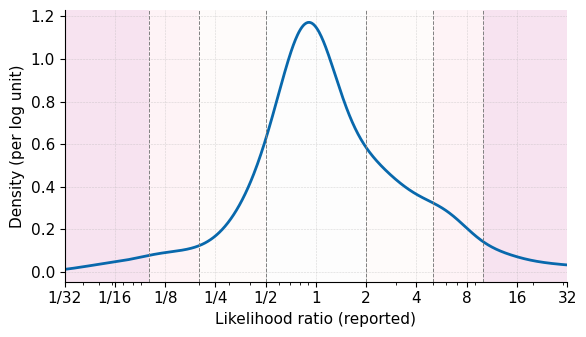

In [7]:
# --- improved KDE plot ----------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy.stats import gaussian_kde

plt.rcParams.update({"font.size": 11, "axes.spines.right": False,
                     "axes.spines.top": False})

lr = np.exp(df["ln_lr_reported"].dropna().values)
log_lr = np.log10(lr)
kde = gaussian_kde(log_lr, bw_method="scott")

low, high = 1/32, 32
x_log  = np.linspace(np.log10(low), np.log10(high), 700)
pdf    = kde(x_log)
pdf   /= np.trapz(pdf, x_log)

lr_x = 10**x_log

# qualitative‑band shading (unchanged)
cuts = [0.1, 0.2, 0.5, 2, 5, 10]
bands = [(low, 0.1), (0.1,0.2), (0.2,0.5), (0.5,2),
         (2,5), (5,10), (10,high)]
light = "#fde0dd"; mid = "#fa9fb5"; dark = "#c51b8a"
band_cols = [dark, mid, light, "#f0f0f0", light, mid, dark]

fig, ax = plt.subplots(figsize=(6, 3.5))

for (a, b), col in zip(bands, band_cols):
    ax.axvspan(a, b, color=col, alpha=0.12, lw=0)

ax.plot(lr_x, pdf, lw=2.0, color="#0868ac")        # curve only

# log ticks as fractions ---------------------------------------------------
ticks = [1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32]
tick_labels = [("1/"+str(int(1/t))) if t < 1 else f"{int(t)}" for t in ticks]

ax.set_xscale("log")
ax.set_xlim(low, high)
ax.set_xlabel("Likelihood ratio (reported)")
ax.set_ylabel("Density (per log unit)")

ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))

# vertical reference lines only -------------------------------------------
for c in cuts:
    ax.axvline(c, ls="--", lw=0.7, color="grey")

ax.grid(which="major", ls="--", lw=0.4, alpha=0.5)
ax.grid(which="minor", lw=0, alpha=0)

fig.tight_layout()
fig.savefig("lr_reported_kde_pubready_nomedian.pdf",
            dpi=600, bbox_inches="tight")
print("Saved figure to lr_reported_kde_pubready_nomedian.pdf")

### Create Bland-Altman Plots for each - all categories

Only logged Bland-Altman plots make sense.

## Main Figure: 

Combined Figure - all features, using Pinguoin Bland-Altman package to generate confidence intervals. 

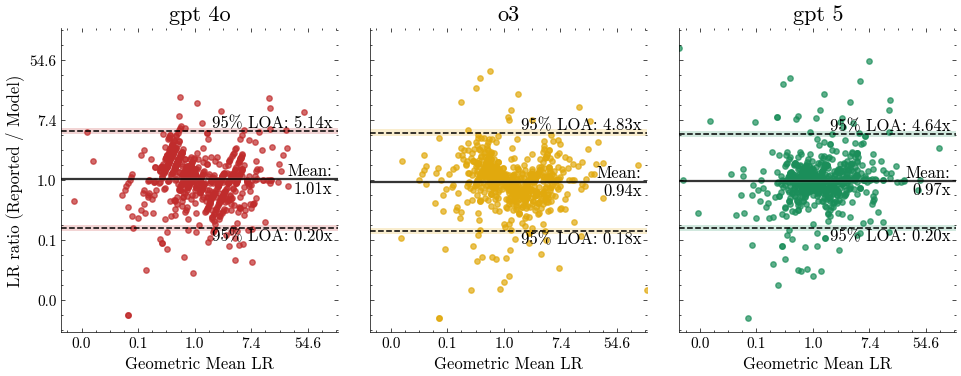

In [8]:
plt.style.use(["science", "no-latex"])

# ── helper: convert ln‑ticks to LR values ────────────────────────────
def exp_fmt(x, _):
    return f"{np.exp(x):.1f}"
fmt = FuncFormatter(exp_fmt)

# ── panel specification ──────────────────────────────────────────────
panels = [
    ("gpt 4o", df["ln_lr_gpt-4o-2024-11-20"], "#c02c2c"),  # red
    ("o3",      df["ln_lr_o3-2025-04-16"],      "#e1a90d"),  # amber
    ("gpt 5", df["ln_lr_gpt-5"],     "#1b8e5a"),  # emerald
]
ln_ref = df["ln_lr_reported"]

# ── global limits (across all three models) ─────────────────────────
means = [(ln_ref + m) / 2 for _, m, _ in panels]
diffs = [ln_ref - m       for _, m, _ in panels]
xlim  = (np.concatenate(means).min(), np.concatenate(means).max())
ylim  = (-1.1*np.abs(np.concatenate(diffs)).max(),
          1.1*np.abs(np.concatenate(diffs)).max())

# ── figure scaffold ─────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 4))

for ax, (title, ln_model, colour) in zip(axes, panels):

    # Draw BA panel with Pingouin
    pg.plot_blandaltman(
        ln_ref, ln_model,
        ax=ax,
        marker="o", s=15, alpha=0.7, color=colour
    )

    # Re‑style the three horizontal lines
    ax.lines[0].set(color="black", lw=1.1, ls="-")   # mean
    for ln in ax.lines[1:]:
        ln.set(color="black", lw=1.1, ls="--")       # LoA

    # Remove Pingouin's default annotations
    for t in list(ax.texts):
        t.remove()

    # Custom anti‑logged labels
    ln_diff = ln_ref - ln_model
    mu      = ln_diff.mean()
    sd      = ln_diff.std(ddof=1)
    up, lo  = mu + 1.96*sd, mu - 1.96*sd

    trans = blended_transform_factory(ax.transAxes, ax.transData)
    ax.text(0.98, mu, f"Mean:\n{np.exp(mu):.2f}x",
            transform=trans, ha="right", va="center", fontsize=12)
    ax.text(0.98, up, f"95% LOA: {np.exp(up):.2f}x",
            transform=trans, ha="right", va="bottom", fontsize=12)
    ax.text(0.98, lo, f"95% LOA: {np.exp(lo):.2f}x",
            transform=trans, ha="right", va="top", fontsize=12)

    # Axis limits and formatting
    ax.set_title(title, fontsize=16)
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.xaxis.set_major_formatter(fmt)
    ax.yaxis.set_major_formatter(fmt)
    ax.set_xlabel("Geometric Mean LR", fontsize=12)
    if ax is axes[0]:
        ax.set_ylabel("LR ratio (Reported / Model)", fontsize=12)

# Outer‑label housekeeping
for ax in axes[1:]:
    ax.set_ylabel("")
axes[-1].set_xlabel("Geometric Mean LR", fontsize=12)  # rightmost already set; keeps symmetry

fig.tight_layout()
fig.savefig("bland_altman_3panel_pingouin.pdf",
            format="pdf", bbox_inches="tight")

## Subgroup Figure

Divided by the type of feature, all 3 models. 

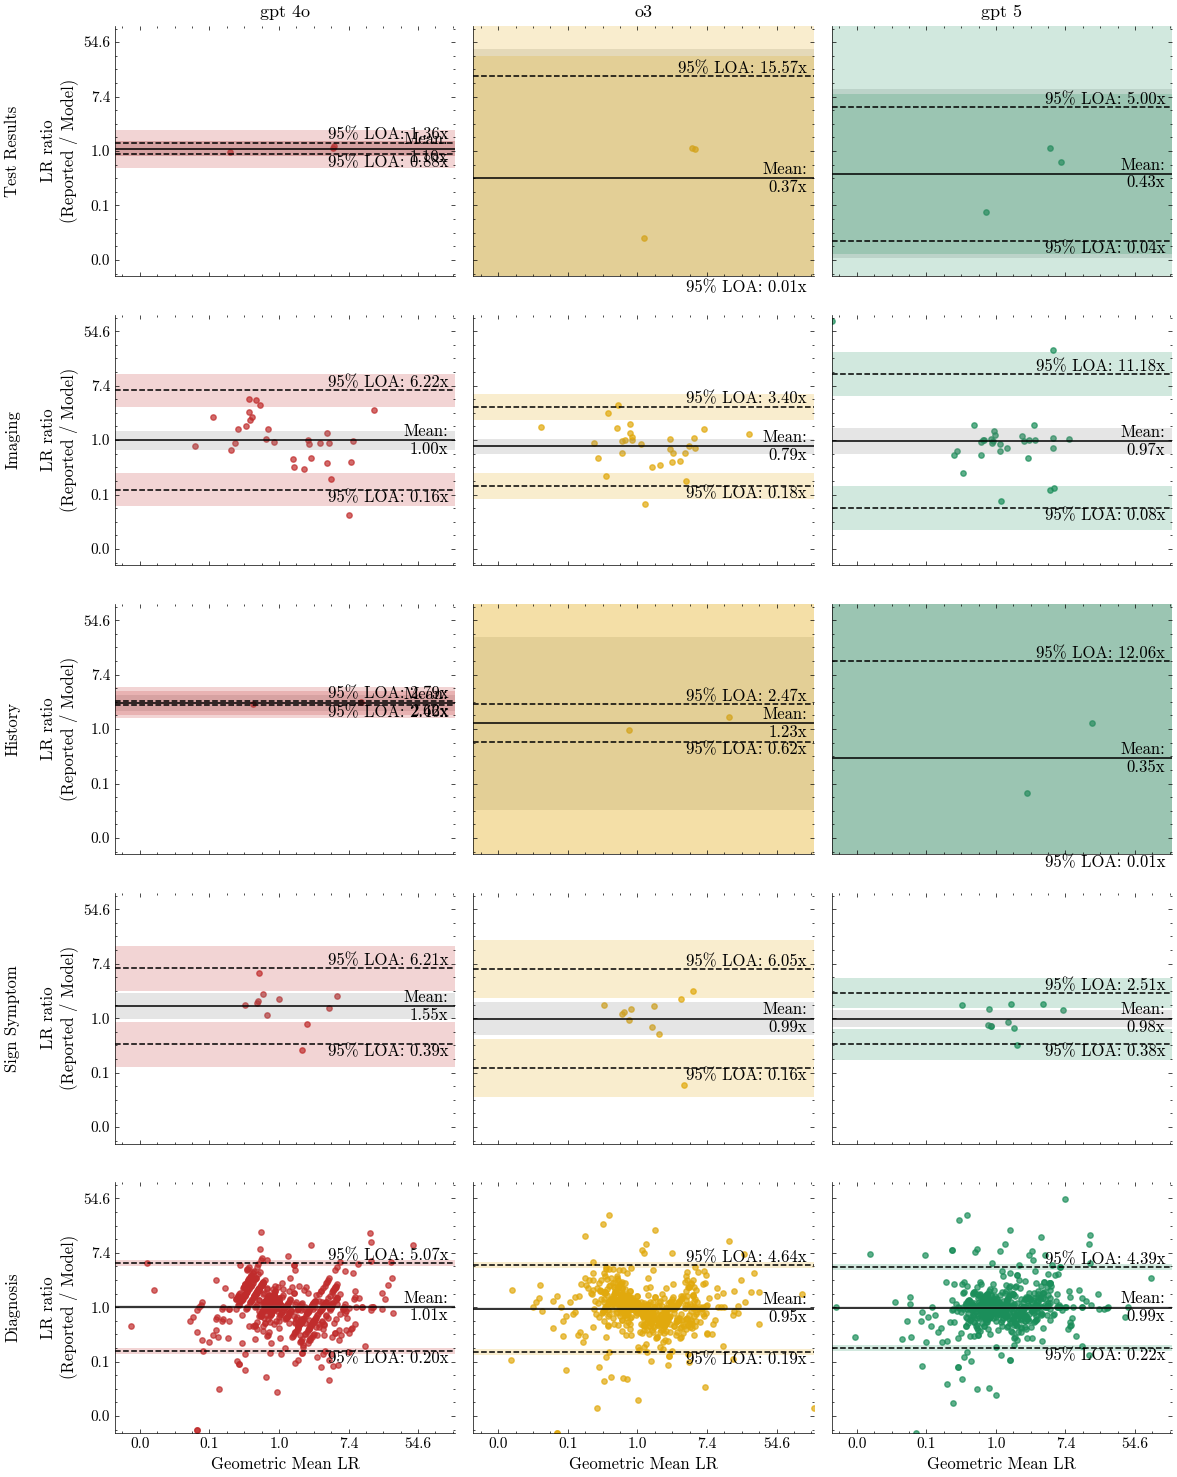

In [9]:
"""
5 × 3 Bland–Altman grid (Pingouin version)
• Rows = feature types              (test / imaging / history / signs / diagnosis)
• Cols = LLM models                 (4o‑mini, 4o, o3‑mini)
• Natural‑log data internally; axes and labels shown as LR
• Shared limits, SciencePlots styling, colour‑coded dots
"""

plt.style.use(["science", "no-latex"])

# ── helper to show LR values on ln axis ─────────────────────────────
def exp_fmt(x, _):
    return f"{np.exp(x):.1f}"
fmt = FuncFormatter(exp_fmt)

# ── model columns & colours (3 columns) ────────────────────────────
MODELS = [
    ("gpt 4o", df["ln_lr_gpt-4o-2024-11-20"], "#c02c2c"),  # red
    ("o3",      df["ln_lr_o3-2025-04-16"],      "#e1a90d"),  # amber
    ("gpt 5", df["ln_lr_gpt-5"],     "#1b8e5a"),  # emerald
]

# ── feature‑type rows (5 rows) ─────────────────────────────────────
ROWS = ["test_results", "imaging", "history", "sign_symptom", "diagnosis"]

ln_ref = df["ln_lr_reported"]

# ── global x/y limits across every (row × model) slice ─────────────
means_all, diffs_all = [], []
for _, ln_mod, _ in MODELS:
    for row in ROWS:
        m = df[row] == 1
        if m.any():
            means_all.append((ln_ref[m] + ln_mod[m]) / 2)
            diffs_all.append(ln_ref[m] - ln_mod[m])

xlim = (np.concatenate(means_all).min(), np.concatenate(means_all).max())
ylim = (-1.0*np.abs(np.concatenate(diffs_all)).max(),
         1.0*np.abs(np.concatenate(diffs_all)).max())

# ── build the 5×3 grid ─────────────────────────────────────────────
fig, axes = plt.subplots(len(ROWS), len(MODELS),
                         sharex=True, sharey=True,
                         figsize=(12, 15))

for r, row in enumerate(ROWS):
    mask_row = df[row] == 1
    row_title = row.replace("_", " ").title()

    for c, (model_name, ln_mod, colour) in enumerate(MODELS):
        ax = axes[r, c]
        if not mask_row.any():
            ax.axis("off")
            ax.set_title(f"{row_title}\n(no rows)")
            continue

        # ── Pingouin Bland‑Altman panel ────────────────────────────
        pg.plot_blandaltman(
            ln_ref[mask_row], ln_mod[mask_row],
            ax=ax,
            marker="o", s=15, alpha=0.7, color=colour
        )

        # Re‑style mean and LoA lines added by Pingouin
        ax.lines[0].set(color="black", lw=1.1, ls="-")   # mean
        for ln in ax.lines[1:]:
            ln.set(color="black", lw=1.1, ls="--")       # LoA

        # Remove Pingouin’s default labels
        for t in list(ax.texts):
            t.remove()

        # ── custom anti‑logged μ and LoA labels ───────────────────
        ln_diff = ln_ref[mask_row] - ln_mod[mask_row]
        mu  = ln_diff.mean()
        sd  = ln_diff.std(ddof=1)
        up, lo = mu + 1.96*sd, mu - 1.96*sd

        trans = blended_transform_factory(ax.transAxes, ax.transData)
        ax.text(0.98, mu, f"Mean:\n{np.exp(mu):.2f}x",
                transform=trans, ha="right", va="center", fontsize=12)
        ax.text(0.98, up, f"95% LOA: {np.exp(up):.2f}x",
                transform=trans, ha="right", va="bottom", fontsize=12)
        ax.text(0.98, lo, f"95% LOA: {np.exp(lo):.2f}x",
                transform=trans, ha="right", va="top", fontsize=12)

        # ── axes & ticks ─────────────────────────────────────────
        ax.set_xlim(xlim); ax.set_ylim(ylim)
        ax.xaxis.set_major_formatter(fmt)
        ax.yaxis.set_major_formatter(fmt)

        # column headers & row labels
        if r == 0:
            ax.set_title(model_name, fontsize=13, pad=6)
        if c == 0:
            ax.set_ylabel(f"{row_title}\n\nLR ratio\n(Reported / Model)",
                fontsize=12
            )

        if r == len(ROWS) - 1:
            ax.set_xlabel("Geometric Mean LR", fontsize=12)

# keep outer tick labels only
for ax in axes.flat:
    ax.label_outer()

fig.tight_layout(h_pad=1.3, w_pad=1.2)
fig.savefig("bland_altman_5x3_grid_pingouin.pdf",
            format="pdf", bbox_inches="tight")

### By positive vs negative evidence 

LR (reported) > 1 vs LR < 1 

Saved figure to bland_altman_by_LR_sign_pingouin.pdf


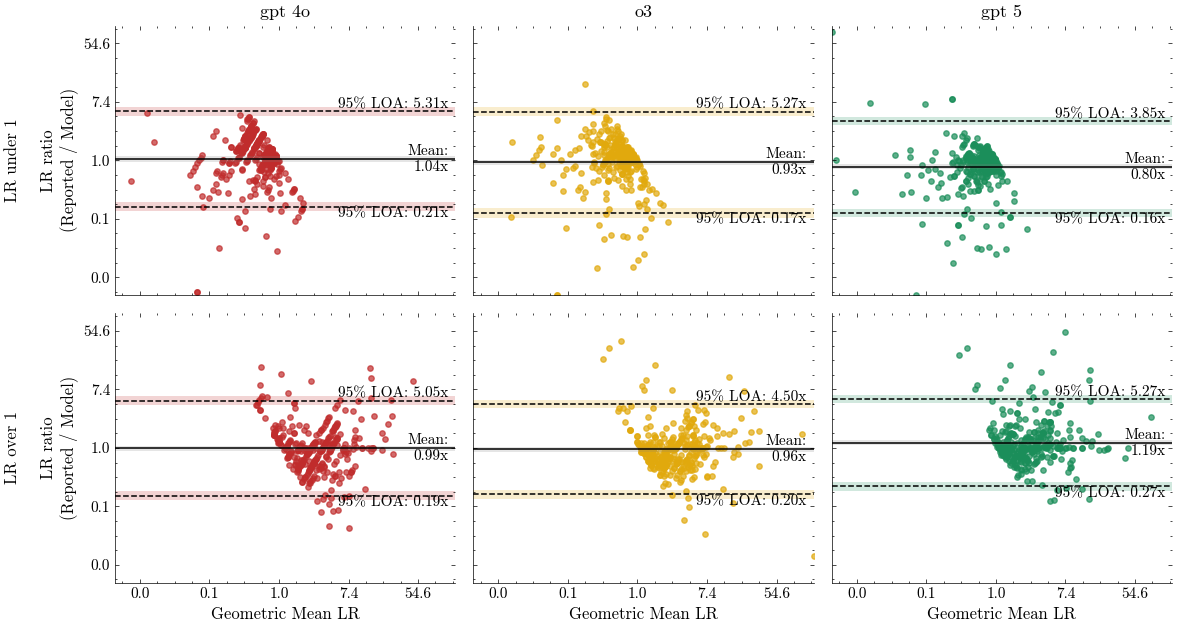

In [10]:
"""
2 × 3 Bland–Altman grid (Pingouin version)
• Rows = evidence direction         (LR < 1  vs  LR > 1)
• Cols = LLM models                 (4o‑mini, 4o, o3‑mini)
• Natural‑log data internally; axes and labels shown as LR
• Shared limits, SciencePlots styling, colour‑coded dots
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.transforms import blended_transform_factory
import pingouin as pg

plt.style.use(["science", "no-latex"])

# ── helper to show LR values on ln axis ───────────────────────────
def exp_fmt(x, _):
    return f"{np.exp(x):.1f}"
fmt = FuncFormatter(exp_fmt)

# ── model columns & colours (3) ───────────────────────────────────
MODELS = [
    ("gpt 4o", df["ln_lr_gpt-4o-2024-11-20"], "#c02c2c"),  # red
    ("o3",      df["ln_lr_o3-2025-04-16"],      "#e1a90d"),  # amber
    ("gpt 5", df["ln_lr_gpt-5"],     "#1b8e5a"),  # emerald
]

ln_ref = df["ln_lr_reported"]

# ── define the two evidence‑direction rows ───────────────────────
ROW_DEFS = [
    ("LR under 1",  ln_ref <  0),   # negative evidence
    ("LR over 1",  ln_ref >  0),   # positive evidence
]

# ── global x/y limits across every (row × model) slice ───────────
means_all, diffs_all = [], []
for _, ln_mod, _ in MODELS:
    for _, mask in ROW_DEFS:
        m = mask & ln_mod.notna()
        if m.any():
            means_all.append((ln_ref[m] + ln_mod[m]) / 2)
            diffs_all.append(ln_ref[m] - ln_mod[m])

xlim = (np.concatenate(means_all).min(), np.concatenate(means_all).max())
ylim = (-1.0 * np.abs(np.concatenate(diffs_all)).max(),
         1.0 * np.abs(np.concatenate(diffs_all)).max())

# ── build the 2×3 grid ───────────────────────────────────────────
fig, axes = plt.subplots(len(ROW_DEFS), len(MODELS),
                         sharex=True, sharey=True,
                         figsize=(12, 6.5))

for r, (row_title, row_mask) in enumerate(ROW_DEFS):
    for c, (model_name, ln_mod, colour) in enumerate(MODELS):
        ax = axes[r, c]
        mask = row_mask & ln_mod.notna()

        if not mask.any():
            ax.axis("off")
            ax.set_title(f"{row_title}\n(no rows)")
            continue

        # ── Pingouin Bland‑Altman panel ───────────────────────────
        pg.plot_blandaltman(
            ln_ref[mask], ln_mod[mask],
            ax=ax,
            marker="o", s=15, alpha=0.7, color=colour
        )

        # Restyle mean and LoA lines
        ax.lines[0].set(color="black", lw=1.1, ls="-")    # mean
        for ln in ax.lines[1:]:
            ln.set(color="black", lw=1.1, ls="--")         # LoA

        # Remove Pingouin’s default text
        for t in list(ax.texts):
            t.remove()

        # ── custom anti‑logged μ and LoA labels ────────────────
        ln_diff = ln_ref[mask] - ln_mod[mask]
        mu  = ln_diff.mean()
        sd  = ln_diff.std(ddof=1)
        up, lo = mu + 1.96*sd, mu - 1.96*sd

        trans = blended_transform_factory(ax.transAxes, ax.transData)
        ax.text(0.98, mu, f"Mean:\n{np.exp(mu):.2f}x",
                transform=trans, ha="right", va="center", fontsize=11)
        ax.text(0.98, up, f"95% LOA: {np.exp(up):.2f}x",
                transform=trans, ha="right", va="bottom", fontsize=11)
        ax.text(0.98, lo, f"95% LOA: {np.exp(lo):.2f}x",
                transform=trans, ha="right", va="top", fontsize=11)

        # ── axis limits & tick format ──────────────────────────
        ax.set_xlim(xlim); ax.set_ylim(ylim)
        ax.xaxis.set_major_formatter(fmt)
        ax.yaxis.set_major_formatter(fmt)

        # headers and labels
        if r == 0:
            ax.set_title(model_name, fontsize=13, pad=6)
        if c == 0:
            ax.set_ylabel(f"{row_title}\n\nLR ratio\n(Reported / Model)",
                          fontsize=12)
        if r == len(ROW_DEFS) - 1:
            ax.set_xlabel("Geometric Mean LR", fontsize=12)

# keep only outer tick labels
for ax in axes.flat:
    ax.label_outer()

fig.tight_layout(h_pad=1.2, w_pad=1.2)
fig.savefig("bland_altman_by_LR_sign_pingouin.pdf",
            format="pdf", bbox_inches="tight")

print("Saved figure to bland_altman_by_LR_sign_pingouin.pdf")

Test to see if there's a signficant difference between the subfroups in mean bias or limits of agreement width

In [11]:
# ------------------------------------------------------------------
# Compare bias (Welch t) and spread (Levene) between LR<1 vs LR>1
# for each model
# ------------------------------------------------------------------
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, levene

# log‑reported LR in dataframe
ln_ref = df["ln_lr_reported"]

# models to evaluate  (label, log‑predicted‑LR column)



MODELS = [
    ("gpt 4o", df["ln_lr_gpt-4o-2024-11-20"]), 
    ("o3",      df["ln_lr_o3-2025-04-16"]),
    ("gpt 5", df["ln_lr_gpt-5"])
]

# sub‑group masks
ROW_DEFS = [
    ("LR < 1",  ln_ref < 0),   # negative evidence
    ("LR > 1",  ln_ref > 0)    # positive evidence
]

results = []

for model_name, ln_mod in MODELS:
    # paired log‑ratio vector
    ln_diff = ln_ref - ln_mod

    # split into the two subgroups
    grp_vals = []
    for _, mask in ROW_DEFS:
        vals = ln_diff[mask & ln_mod.notna()].dropna().values
        grp_vals.append(vals)

    # Welch's t‑test on means (bias)
    t_stat, p_t = ttest_ind(
        grp_vals[0], grp_vals[1],
        equal_var=False, nan_policy="omit"
    )

    # Levene test on variances (LoA width proxy)
    # center='mean' (standard Levene); use 'median' for Brown–Forsythe
    lev_stat, p_lev = levene(
        grp_vals[0], grp_vals[1],
        center='mean'
    )

    results.append({
        "model"        : model_name,
        "n_neg"        : len(grp_vals[0]),
        "n_pos"        : len(grp_vals[1]),
        "Welch_t"      : t_stat,
        "p_t"          : p_t,
        "Levene_F"     : lev_stat,
        "p_Levene"     : p_lev
    })

# tidy table
subgroup_tests = pd.DataFrame(results)

# display (scientific notation for p‑values)
with pd.option_context("display.float_format", lambda x: f"{x:.3g}"):
    display(subgroup_tests)

,model,n_neg,n_pos,Welch_t,p_t,Levene_F,p_Levene
0,gpt 4o,341,338,0.807,0.42,0.333,0.564
1,o3,341,338,-0.371,0.71,0.53,0.467
2,gpt 5,341,338,-6.68,4.91e-11,0.143,0.706


## Analysis - are there significant trends? 

### Overall

First, evaluating all predictions - intended tests: 


Progressing from 4o mini vs 4o vs o3-mini is there: 
1. Decreasing width of limits of agreement as the models become more advanced? 
2. Decreasing mean bias as the models become more advanced? 

Tests can be pairwise rather than tests for trend

| Question addressed | Statistical test (paired data) | Null hypothesis (H₀) |
|--------------------|--------------------------------|----------------------|
| Are the Limits-of-Agreement widths (σ) different? | **Pitman–Morgan variance test** | σ²<sub>model A</sub> = σ²<sub>model B</sub> |
| Is the average bias (μ) different? | **Paired t-test** on the two log-difference vectors | μ<sub>model A</sub> = μ<sub>model B</sub> |
| Do both bias **and** spread differ simultaneously? | **Bradley–Blackwood F-test** | μ<sub>A</sub> = μ<sub>B</sub> **and** σ²<sub>A</sub> = σ²<sub>B</sub> |

In [12]:
import itertools, numpy as np, pandas as pd, scipy.stats as st

# [ ] TODO: I would like to confirm that these estimates are correct with an external package
# ---------- helper functions ---------------------------------------------

def pitman_morgan(x, y):
    """ Classic paired‐sample variance test. Algorithm: 
    ① Remove NaNs → ok. 
    ② Build sum (s) and difference (d). 
    ③ Pearson r between s,d. 
    ④ Convert r to t with n–2 df. 
    ⑤ Two‑sided p via st.t.sf.
"""
    ok = np.isfinite(x) & np.isfinite(y)
    x, y = x[ok], y[ok]
    n    = len(x)
    s, d = x + y, x - y
    r    = np.corrcoef(s, d)[0, 1]
    t    = r * np.sqrt(n - 2) / np.sqrt(1 - r**2)
    p    = 2 * st.t.sf(abs(t), n - 2)
    return t, p

def bradley_blackwood(x, y):
    """ Joint test: equality of both means and variances. Steps: 
    ① Remove NaNs. 
    ② Response d = y–x; predictor s = (y+x)/2. 
    ③ Fit intercept + s via OLS. 
    ④ rss₀ = Σd², rss₁ = Σresid². 
    ⑤ F(2, n–2) from the usual nested‑model formula.
"""
    ok = np.isfinite(x) & np.isfinite(y)
    x, y = x[ok], y[ok]
    n    = len(x)
    d    = y - x
    s    = (y + x) / 2
    X    = np.column_stack((np.ones(n), s))
    beta = np.linalg.lstsq(X, d, rcond=None)[0]
    rss1 = ((d - X @ beta) ** 2).sum()
    rss0 = (d ** 2).sum()
    F    = ((rss0 - rss1) / 2) / (rss1 / (n - 2))
    p    = st.f.sf(F, 2, n - 2)
    return F, p

# ---------- ln‑difference vectors ----------------------------------------
ln_ref = df["ln_lr_reported"]
ln_diffs = {
    "gpt 4o": ln_ref - df["ln_lr_gpt-4o-2024-11-20"],
    "o3"     : ln_ref - df["ln_lr_o3-2025-04-16"],
    "gpt 5": ln_ref - df["ln_lr_gpt-5"],
}

rows = []

"""For every ordered pair: 
① Mask rows with complete data for both models. 
② x,y = ln‑errors of Model A & B. 
③ Basic descriptives: • mu_ln, se, 95 % CI, two‑sided paired t. 
④ Convert bias back to multiplicative scale (exp). 
⑤ loa_w_A/B = 1.96·2·SD = full width of the Bland‑Altman Limits‑of‑Agreement. 
⑥ Run Pitman‑Morgan and Bradley‑Blackwood. 
⑦ Append tidy row‑dict.
"""

for (lab_a, d_a), (lab_b, d_b) in itertools.combinations(ln_diffs.items(), 2):
    mask = d_a.notna() & d_b.notna()
    x, y = d_a[mask].values, d_b[mask].values
    n    = len(x)

    diff  = x - y
    mu_ln = diff.mean()
    se    = diff.std(ddof=1) / np.sqrt(n)
    t_b   = mu_ln / se
    p_b   = 2 * st.t.sf(abs(t_b), n - 1)
    ci_lo, ci_hi = st.t.interval(0.95, n - 1, loc=mu_ln, scale=se)

    # convert bias to multiplicative (“×”) units
    mu_ratio = np.exp(mu_ln)
    ci_ratio = np.exp([ci_lo, ci_hi])

    loa_w_A = 1.96 * 2 * x.std(ddof=1)
    loa_w_B = 1.96 * 2 * y.std(ddof=1)

    pm_t, pm_p = pitman_morgan(x, y)
    bb_F, bb_p = bradley_blackwood(x, y)

    rows.append(dict(
        comparison=f"{lab_a} vs {lab_b}", n=n,

        bias_ln = mu_ln,
        bias_ratio = mu_ratio,
        ci95_ln_low = ci_lo,  ci95_ln_hi = ci_hi,
        ci95_ratio_low = ci_ratio[0], ci95_ratio_hi = ci_ratio[1],

        t_stat = t_b,
        p_t    = p_b,

        loa_width_A = loa_w_A,
        loa_width_B = loa_w_B,

        pm_t = pm_t,
        pm_p = pm_p,
        bb_F = bb_F,
        bb_p = bb_p
    ))

df_out = pd.DataFrame(rows)

# display with scientific notation for p-values
with pd.option_context("display.float_format", lambda v: f"{v:.3g}"):
    display(df_out)

,comparison,n,bias_ln,bias_ratio,ci95_ln_low,ci95_ln_hi,ci95_ratio_low,ci95_ratio_hi,t_stat,p_t,loa_width_A,loa_width_B,pm_t,pm_p,bb_F,bb_p
0,gpt 4o vs o3,700,0.0782,1.08,0.0246,0.132,1.02,1.14,2.87,0.00428,3.24,3.28,-0.35,0.726,4.16,0.0159
1,gpt 4o vs gpt 5,700,0.0479,1.05,-0.0121,0.108,0.988,1.11,1.57,0.117,3.24,3.14,1.02,0.306,1.75,0.174
2,o3 vs gpt 5,700,-0.0303,0.97,-0.0785,0.018,0.925,1.02,-1.23,0.218,3.28,3.14,1.59,0.113,2.02,0.133


In [13]:
# ---------------------------------------------------------------------
# coverage‑interval table on RATIO scale for the chosen models
# prerequisites already present in notebook:
#   • ln_diffs  (dict[label → Series of log‑errors])
#   • numpy as np, pandas as pd, scipy.stats as st
# ---------------------------------------------------------------------

models = ["gpt 4o", "o3", "gpt 5"]          # keys for ln_dif  models to report

# ---------------------------------------------------------------
# Build “pretty” tables with combined point‑estimate and CI
# ---------------------------------------------------------------

def prettify(tbl, digits=2):
    """
    Re‑shape a coverage‑interval DataFrame so that:

      • Column 1 : 'Coverage'  (as %)
      • Column 2 : 'Lower edge'  →  point (loCI, hiCI)  using commas
      • Column 3 : 'Upper edge'  →  point (loCI - hiCI) using a dash

    All numbers rounded to <digits> decimal places.
    """
    fmt = f"{{:.{digits}f}}"
    out = pd.DataFrame({
        "Coverage"   : tbl["coverage"],
        "Lower edge" : tbl.apply(
            lambda r: f"{fmt.format(r['lower'])} "
                      f"({fmt.format(r['lower_ci_low'])}, "
                      f"{fmt.format(r['lower_ci_high'])})", axis=1),
        "Upper edge" : tbl.apply(
            lambda r: f"{fmt.format(r['upper'])} "
                      f"({fmt.format(r['upper_ci_low'])} - "
                      f"{fmt.format(r['upper_ci_high'])})", axis=1)
    })
    return out


def coverage_table_ratio(errors: pd.Series,
                         coverages=(0.50, 0.75, 0.90, 0.95, 0.99),
                         conf_level=0.95) -> pd.DataFrame:
    """
    Return a DataFrame of symmetric coverage intervals expressed
    as multiplicative ratios (exp of log‑limits) together with the
    95 % CI of each limit.

    Formulae follow Bland & Altman (1999) assuming approximate
    normality of log‑errors.
    """
    x      = errors.dropna().values
    n      = len(x)
    mean_l = x.mean()
    sd_l   = x.std(ddof=1)
    t_mult = st.t.ppf(1 - (1 - conf_level)/2, n-1)

    rows = []
    for p in coverages:
        z          = st.norm.ppf(0.5 + p/2)           # two‑sided multiplier
        lo_l       = mean_l - z*sd_l                  # lower limit (ln)
        hi_l       = mean_l + z*sd_l                  # upper limit (ln)
        se_lim     = sd_l * np.sqrt(1/n + z**2/(2*(n-1)))

        # CI for each limit on ln‑scale
        lo_ci_l, lo_ci_h = lo_l - t_mult*se_lim, lo_l + t_mult*se_lim
        hi_ci_l, hi_ci_h = hi_l - t_mult*se_lim, hi_l + t_mult*se_lim

        rows.append(dict(
            coverage           = int(p*100),
            lower              = np.exp(lo_l),
            upper              = np.exp(hi_l),
            lower_ci_low       = np.exp(lo_ci_l),
            lower_ci_high      = np.exp(lo_ci_h),
            upper_ci_low       = np.exp(hi_ci_l),
            upper_ci_high      = np.exp(hi_ci_h),
        ))
    return pd.DataFrame(rows)


# build and display tables
tables_ratio = {lab: coverage_table_ratio(ln_diffs[lab]) for lab in models}

# build and show the pretty tables
with pd.option_context("display.max_colwidth", None):   # prevent wrapping
    for lab in models:
        pretty = prettify(tables_ratio[lab], digits=2)
        print(f"\nModel: {lab}")
        display(pretty)


Model: gpt 4o


,Coverage,Lower edge,Upper edge
0,50,"0.58 (0.54, 0.62)",1.77 (1.66 - 1.90)
1,75,"0.39 (0.36, 0.42)",2.63 (2.43 - 2.85)
2,90,"0.26 (0.24, 0.29)",3.96 (3.60 - 4.35)
3,95,"0.20 (0.18, 0.22)",5.14 (4.63 - 5.71)
4,99,"0.12 (0.11, 0.14)",8.56 (7.53 - 9.72)



Model: o3


,Coverage,Lower edge,Upper edge
0,50,"0.53 (0.50, 0.57)",1.65 (1.54 - 1.77)
1,75,"0.36 (0.33, 0.39)",2.46 (2.27 - 2.66)
2,90,"0.24 (0.22, 0.26)",3.71 (3.38 - 4.08)
3,95,"0.18 (0.16, 0.20)",4.83 (4.35 - 5.37)
4,99,"0.11 (0.10, 0.12)",8.09 (7.11 - 9.20)



Model: gpt 5


,Coverage,Lower edge,Upper edge
0,50,"0.56 (0.53, 0.60)",1.66 (1.55 - 1.77)
1,75,"0.39 (0.36, 0.42)",2.43 (2.25 - 2.62)
2,90,"0.26 (0.24, 0.28)",3.61 (3.29 - 3.95)
3,95,"0.20 (0.18, 0.22)",4.64 (4.20 - 5.14)
4,99,"0.12 (0.11, 0.14)",7.60 (6.72 - 8.60)


In [14]:
# ── prerequisites ────────────────────────────────────────────────
# variables expected to exist:  tables_ratio  (dict[label → DataFrame])
#                               models        (list of model labels)
# pip install python-docx  if not already available
from docx import Document

def _prettify(df: pd.DataFrame, digits: int = 2):
    fmt = f"{{:.{digits}f}}"
    header = [["Coverage Interval", "Lower edge (95% CI)", "Upper edge (95% CI)"]]
    body = [
        [
            f"{int(r['coverage'])}%",
            f"{fmt.format(r['lower'])}x "
            f"({fmt.format(r['lower_ci_low'])}x - {fmt.format(r['lower_ci_high'])}x)",
            f"{fmt.format(r['upper'])} "
            f"({fmt.format(r['upper_ci_low'])}x - {fmt.format(r['upper_ci_high'])}x)",
        ]
        for _, r in df.iterrows()
    ]
    return header + body

# ── build the Word document ──────────────────────────────────────
doc = Document()
doc.add_heading("LOA Coverage Tables", level=1)

for lab in models:
    doc.add_heading(f"Model: {lab}", level=2)
    rows = _prettify(tables_ratio[lab], digits=2)

    table = doc.add_table(rows=len(rows), cols=3)
    for i, row in enumerate(rows):
        for j, text in enumerate(row):
            table.cell(i, j).text = text
    doc.add_paragraph()      # blank line between model tables

# ── save ─────────────────────────────────────────────────────────
doc.save("LOA tables.docx")
print("Saved to  LOA tables.docx")

Saved to  LOA tables.docx


In [20]:
# If needed:
# %pip install scikit-learn krippendorff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix

# ---------- Utilities on ordered categories ----------
def _to_codes(series: pd.Series, categories: list[str]) -> np.ndarray:
    """Map ordered categorical labels to integer codes 0..K-1; NaNs -> -1."""
    cat = pd.Categorical(series, categories=categories, ordered=True)
    return cat.codes  # -1 denotes missing

def _weights_matrix(k: int, scheme: str | None):
    """Return KxK weight matrix W_ij in [0,1]."""
    if scheme is None:  # unweighted
        return np.eye(k, dtype=float)
    D = np.abs(np.subtract.outer(np.arange(k), np.arange(k))).astype(float)
    if k <= 1:
        return np.ones((k, k), dtype=float)
    if scheme == "linear":
        return 1.0 - D / (k - 1)
    if scheme == "quadratic":
        return 1.0 - (D / (k - 1))**2
    raise ValueError("scheme must be None, 'linear', or 'quadratic'")

def _cohen_kappa_from_cm(cm: np.ndarray, W: np.ndarray | None = None) -> tuple[float, float, float]:
    """
    Cohen's kappa (general/weighted). 
    cm: KxK confusion counts for (reference as rows, model as cols).
    W:  KxK weights in [0,1]; None -> unweighted (identity).
    Returns: (kappa, observed_agreement, expected_agreement)
    """
    cm = np.asarray(cm, dtype=float)
    N = cm.sum()
    if N == 0:
        return (np.nan, np.nan, np.nan)
    P = cm / N
    if W is None:
        W = np.eye(cm.shape[0], dtype=float)
    p_row = P.sum(axis=1)  # reference prevalence by category
    p_col = P.sum(axis=0)  # model prevalence by category
    Ao = float((W * P).sum())
    Pe = float((W * np.outer(p_row, p_col)).sum())
    return ((Ao - Pe) / (1 - Pe) if (1 - Pe) else np.nan, Ao, Pe)

def _gwet_ac_from_cm(cm: np.ndarray, W: np.ndarray | None = None) -> tuple[float, float, float]:
    """
    Gwet's AC1/AC2 (two raters). 
    W=None -> AC1 (unweighted). W provided -> AC2 with those weights.
    Expected agreement uses pooled prevalence p_bar = 0.5*(p_row + p_col).
    Returns: (AC, observed_agreement, expected_agreement)
    """
    cm = np.asarray(cm, dtype=float)
    N = cm.sum()
    if N == 0:
        return (np.nan, np.nan, np.nan)
    P = cm / N
    p_row = P.sum(axis=1)
    p_col = P.sum(axis=0)
    p_bar = 0.5 * (p_row + p_col)

    if W is None:
        # AC1
        Ao = float(np.trace(P))
        # Pe = sum p_bar*(1 - p_bar) = 1 - sum p_bar^2
        Pe = float(1.0 - np.sum(p_bar**2))
    else:
        # AC2 with weights
        Ao = float((W * P).sum())
        Pe = float((W * np.outer(p_bar, p_bar)).sum())

    return ((Ao - Pe) / (1 - Pe) if (1 - Pe) else np.nan, Ao, Pe)

def _plot_confusion_heatmap(cm: np.ndarray, categories: list[str], title: str, out_path: str | None = None):
    """Matplotlib-only annotated heatmap; no seaborn."""
    K = len(categories)
    N = cm.sum()
    fig, ax = plt.subplots(figsize=(6.0, 5.6))
    im = ax.imshow(cm, aspect='auto')  # default colormap
    # Annotate counts and percentages
    for i in range(K):
        for j in range(K):
            val = int(cm[i, j])
            pct = (val / N) if N else 0.0
            ax.text(j, i, f"{val}\n({pct:.1%})", ha='center', va='center', fontsize=8)
    ax.set_xticks(range(K)); ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.set_yticks(range(K)); ax.set_yticklabels(categories)
    ax.set_xlabel("Model classification")
    ax.set_ylabel("Reference classification")
    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    if out_path:
        Path(out_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out_path, dpi=160, bbox_inches="tight")
        plt.close(fig)
        return out_path
    return fig

# Optional: Krippendorff's alpha (ordinal). Returns NaN if package is not installed.
try:
    import krippendorff as kd
    def _krippendorff_alpha_ordinal(y_ref_codes: np.ndarray, y_mod_codes: np.ndarray) -> float:
        data = np.vstack([y_ref_codes.astype(float), y_mod_codes.astype(float)])
        data[data < 0] = np.nan
        return float(kd.alpha(reliability_data=data, level_of_measurement='ordinal'))
except Exception:
    def _krippendorff_alpha_ordinal(y_ref_codes: np.ndarray, y_mod_codes: np.ndarray) -> float:
        return np.nan

# ---------- Public API ----------
def ordinal_agreement_summary(
    df: pd.DataFrame,
    ref_lr_col: str = "lr_reported",      # numeric LR column for reference
    model_lr_prefix: str = "lr_",         # numeric LR columns for models start with this
    qual_prefix: str = "qual_",           # where qualitative labels will be placed/looked up
    categories: list[str] | None = None,  # ordered category names; default from your _ordinal_dtype
    out_dir: str = "agreement_plots"      # where to save confusion heatmaps
) -> pd.DataFrame:
    """
    For each model LR column, compare its qualitative labels to the reference's labels
    and compute: percent agreement, Cohen's kappa (unweighted/linear/quadratic),
    Gwet's AC1/AC2 (linear/quadratic), and Krippendorff's alpha (ordinal).
    Also saves an annotated confusion heatmap per comparison.
    """
    # 1) category order
    if categories is None:
        try:
            categories = list(_ordinal_dtype.categories)
        except NameError:
            raise ValueError("Provide 'categories' or ensure _ordinal_dtype is defined.")

    K = len(categories)
    W_lin = _weights_matrix(K, "linear")
    W_qua = _weights_matrix(K, "quadratic")

    # 2) ensure qualitative columns exist (reference + each model)
    def _ensure_qual_col(lr_col: str) -> str:
        qcol = f"{qual_prefix}{lr_col}"
        if qcol not in df.columns:
            lr = pd.to_numeric(df[lr_col], errors="coerce")
            df[qcol] = gen_qual_label(lr)  # uses your function
        return qcol

    ref_qual_col = _ensure_qual_col(ref_lr_col)

    model_lr_cols = [
        c for c in df.columns
        if isinstance(c, str) and c.startswith(model_lr_prefix) and c != ref_lr_col
    ]
    # drop the reference if present among models
    model_lr_cols = [c for c in model_lr_cols if c != ref_lr_col]

    rows = []
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    for mcol in model_lr_cols:
        mod_qual_col = _ensure_qual_col(mcol)

        # 3) align, drop missing
        y_ref = df[ref_qual_col]
        y_mod = df[mod_qual_col]
        mask = y_ref.notna() & y_mod.notna()
        if mask.sum() == 0:
            continue

        ref_codes = _to_codes(y_ref[mask], categories)
        mod_codes = _to_codes(y_mod[mask], categories)

        # Confusion matrix in canonical order
        cm = confusion_matrix(ref_codes, mod_codes, labels=np.arange(K))

        # Percent agreement
        po = (np.trace(cm) / cm.sum()) if cm.sum() else np.nan

        # Cohen's kappa (unweighted, linear, quadratic)
        kappa_u, _, _ = _cohen_kappa_from_cm(cm, W=None)
        kappa_l, _, _ = _cohen_kappa_from_cm(cm, W=W_lin)
        kappa_q, _, _ = _cohen_kappa_from_cm(cm, W=W_qua)

        # Gwet's AC1/AC2
        ac1, _, _ = _gwet_ac_from_cm(cm, W=None)
        ac2_l, _, _ = _gwet_ac_from_cm(cm, W=W_lin)
        ac2_q, _, _ = _gwet_ac_from_cm(cm, W=W_qua)

        # Krippendorff's alpha (ordinal)
        alpha_ord = _krippendorff_alpha_ordinal(ref_codes, mod_codes)

        # Save plot
        title = f"{mod_qual_col} vs {ref_qual_col}"
        out_png = f"{out_dir}/{mod_qual_col}_vs_{ref_qual_col}.png"
        _plot_confusion_heatmap(cm, categories, title, out_png)

        rows.append({
            "model_lr_col": mcol,
            "n": int(mask.sum()),
            "percent_agreement": float(po),
            "cohen_kappa": float(kappa_u),
            "cohen_kappa_linear": float(kappa_l),
            "cohen_kappa_quadratic": float(kappa_q),
            "gwet_ac1": float(ac1),
            "gwet_ac2_linear": float(ac2_l),
            "gwet_ac2_quadratic": float(ac2_q),
            "krippendorff_alpha_ordinal": float(alpha_ord),
            "confusion_png": out_png
        })

    out = pd.DataFrame(rows).set_index("model_lr_col").sort_index()
    return out

In [21]:
# 1) Build the agreement summary across all model LR columns vs reference
summary = ordinal_agreement_summary(
    df,
    ref_lr_col="lr_reported",     # numeric LR column that defines the reference labels
    model_lr_prefix="lr_",        # compare every other lr_* column to the reference
    qual_prefix="qual_",          # qualitative labels will be in 'qual_lr_*' columns
    # categories=list(_ordinal_dtype.categories),  # optional; auto-uses your _ordinal_dtype
    out_dir="agreement_plots"
)

# 2) Inspect results (scan-friendly)
summary[[
    "n",
    "percent_agreement",
    "cohen_kappa", "cohen_kappa_linear", "cohen_kappa_quadratic",
    "gwet_ac1", "gwet_ac2_linear", "gwet_ac2_quadratic",
    "krippendorff_alpha_ordinal",
    "confusion_png"
]].round(3)

,n,percent_agreement,cohen_kappa,cohen_kappa_linear,cohen_kappa_quadratic,gwet_ac1,gwet_ac2_linear,gwet_ac2_quadratic,krippendorff_alpha_ordinal,confusion_png
model_lr_col,,,,,,,,,,
lr_gpt-4o-2024-11-20,681,0.536,0.362,0.537,0.700,-0.596,0.533,0.700,NaN,agreement_plots/qual_lr_gpt-4o-2024-11-20_vs_q...
lr_gpt-5,675,0.668,0.477,0.583,0.684,0.095,0.583,0.683,NaN,agreement_plots/qual_lr_gpt-5_vs_qual_lr_repor...
lr_o3-2025-04-16,671,0.575,0.403,0.561,0.691,-0.422,0.558,0.691,NaN,agreement_plots/qual_lr_o3-2025-04-16_vs_qual_...


Below here - experimenting with the calibration plot diea

In [17]:
# If needed:
# %pip install statsmodels scikit-learn

import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import TheilSenRegressor

# -----------------------
# Helpers
# -----------------------
def _to_numeric_series(s: pd.Series) -> pd.Series:
    """Coerce to numeric; invalid → NaN."""
    return pd.to_numeric(s, errors='coerce')

def _finite_pair(df: pd.DataFrame, xcol: str, ycol: str):
    """Return finite-aligned (x, y) as pd.Series with shared index."""
    x = _to_numeric_series(df[xcol])
    y = _to_numeric_series(df[ycol])
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m]

def _ols_calibration(x: pd.Series, y: pd.Series):
    """
    OLS: y = a + b x. Works with pandas Series so conf_int() returns a DataFrame.
    Returns intercept a, slope b, 95% CI for b, R^2, and the fit object.
    """
    # Ensure name so we can look up the correct slope row
    if x.name is None:
        x = x.rename("x")

    X = sm.add_constant(x, has_constant="add")   # keep as pandas
    fit = sm.OLS(y, X, missing="drop").fit()

    params = fit.params
    # Intercept
    a = float(params["const"]) if "const" in params.index else float(params.iloc[0])
    # Slope (by column name if present, else last param)
    slope_key = x.name if x.name in params.index else params.index[-1]
    b = float(params.loc[slope_key])

    ci = fit.conf_int()
    if hasattr(ci, "loc"):  # DataFrame
        row = ci.loc[slope_key] if slope_key in ci.index else ci.iloc[-1]
        b_lo, b_hi = float(row.iloc[0]), float(row.iloc[1])
    else:  # very defensive; shouldn't happen if we kept pandas
        b_lo, b_hi = float(ci[-1, 0]), float(ci[-1, 1])

    r2 = float(fit.rsquared)
    return a, b, b_lo, b_hi, r2, fit

def _theilsen_calibration(x: pd.Series, y: pd.Series):
    """Robust slope/intercept via Theil–Sen (optional)."""
    reg = TheilSenRegressor(fit_intercept=True, random_state=0)
    reg.fit(x.values.reshape(-1, 1), y.values)
    return float(reg.intercept_), float(reg.coef_[0])

def _err_metrics(x: pd.Series, y: pd.Series):
    """Simple agreement metrics on ln scale."""
    d = (y - x)
    mae = float(d.abs().mean())
    rmse = float(np.sqrt((d**2).mean()))
    me = float(d.mean())  # bias
    return mae, rmse, me

# -----------------------
# Main API
# -----------------------
def compute_calibration_table(
    df: pd.DataFrame,
    reference_col: str = "ln_lr_reported",
    model_prefix: str = "ln_lr_",
    out_csv: str | None = None
) -> pd.DataFrame:
    """
    Build a calibration summary for all ln_lr_* columns vs ln_lr_reported.
    Returns a DataFrame with slope, CI, intercept, R^2, robust slope, and error metrics.
    """
    # Ensure reference exists; if not, build it from lr_reported>0
    if reference_col not in df.columns and "lr_reported" in df.columns:
        df[reference_col] = np.log(pd.to_numeric(df["lr_reported"], errors="coerce").where(
            pd.to_numeric(df["lr_reported"], errors="coerce") > 0
        ))

    # Collect model columns
    model_cols = [
        c for c in df.columns
        if isinstance(c, str) and c.startswith(model_prefix) and c != reference_col
    ]

    # Coerce all relevant columns to numeric
    for c in [reference_col] + model_cols:
        df[c] = _to_numeric_series(df[c])

    rows = []
    for mcol in model_cols:
        x, y = _finite_pair(df, reference_col, mcol)
        n = len(x)
        if n < 5:
            continue  # insufficient data to estimate
        a, b, b_lo, b_hi, r2, fit = _ols_calibration(x, y)
        a_ts, b_ts = _theilsen_calibration(x, y)
        mae, rmse, me = _err_metrics(x, y)
        rows.append({
            "model_col": mcol,
            "n": n,
            "intercept": a,
            "slope": b,
            "slope_ci_low": b_lo,
            "slope_ci_high": b_hi,
            "R2": r2,
            "theilsen_intercept": a_ts,
            "theilsen_slope": b_ts,
            "MAE_ln": mae,
            "RMSE_ln": rmse,
            "MeanError_ln": me
        })

    out = pd.DataFrame(rows).set_index("model_col").sort_values("slope")
    if out_csv:
        out.to_csv(out_csv, index=True)
    return out

def plot_calibration_curve(
    df: pd.DataFrame,
    model_col: str,
    reference_col: str = "ln_lr_reported",
    out_path: str | None = None,
    n_bins: int = 20,
    add_lowess: bool = True,
    add_isotonic: bool = True
):
    """
    Reliability-style plot for ln LRs:
    - x = reference ln LR (ln_lr_reported)
    - y = model ln LR (ln_lr_*)
    Shows identity line, binned mean curve, OLS fit, optional LOWESS and isotonic fits.
    """
    x, y = _finite_pair(df, reference_col, model_col)
    if len(x) < 5:
        return None

    # Axis limits (pad slightly)
    lo = float(np.nanmin(np.r_[x.values, y.values]))
    hi = float(np.nanmax(np.r_[x.values, y.values]))
    pad = 0.05 * (hi - lo) if np.isfinite(hi - lo) and (hi > lo) else 1.0
    lo -= pad; hi += pad

    fig, ax = plt.subplots(figsize=(5.5, 5.5))
    ax.scatter(x, y, s=10, alpha=0.25, label="pairs")

    # Identity line
    ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1.0, label="identity")

    # OLS fit
    a, b, _, _, _, _ = _ols_calibration(x, y)
    xs = np.linspace(lo, hi, 200)
    ax.plot(xs, a + b * xs, linewidth=1.0, label=f"OLS: y={a:.2f}+{b:.2f}x")

    # Binned means (quantiles of x)
    uniq = np.unique(x)
    nb = max(3, min(n_bins, len(uniq)))
    try:
        bins = pd.qcut(x, q=nb, duplicates="drop")
        gb = pd.DataFrame({"x": x, "y": y, "bin": bins}).groupby("bin", observed=True).mean(numeric_only=True)
        ax.plot(gb["x"].values, gb["y"].values, marker="o", linewidth=2.0, label="binned mean")
    except Exception:
        # Fallback: equal-width bins
        bins = pd.cut(x, bins=nb)
        gb = pd.DataFrame({"x": x, "y": y, "bin": bins}).groupby("bin", observed=True).mean(numeric_only=True)
        ax.plot(gb["x"].values, gb["y"].values, marker="o", linewidth=2.0, label="binned mean")

    # LOWESS smooth (nonparametric)
    if add_lowess and len(x) >= 20:
        smth = lowess(y.values, x.values, frac=0.3, return_sorted=True)
        ax.plot(smth[:, 0], smth[:, 1], linewidth=1.0, label="LOWESS")

    # Isotonic regression (monotone recalibration map)
    if add_isotonic and len(x) >= 20:
        iso = IsotonicRegression(out_of_bounds="clip")
        y_iso = iso.fit_transform(x.values, y.values)
        # Plot sorted for a clean curve
        order = np.argsort(x.values)
        ax.plot(x.values[order], y_iso[order], linewidth=1.0, label="Isotonic")

    ax.set_xlabel("reference: ln_lr_reported")
    ax.set_ylabel(f"model: {model_col}")
    ax.set_title(f"Calibration: {model_col} vs ln_lr_reported")
    ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
    ax.legend(frameon=False)

    if out_path:
        Path(out_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out_path, dpi=160, bbox_inches="tight")
        plt.close(fig)
        return out_path
    return fig

def make_all_calibration_plots(
    df: pd.DataFrame,
    reference_col: str = "ln_lr_reported",
    out_dir: str = "calibration_plots",
    n_bins: int = 20,
    add_lowess: bool = True,
    add_isotonic: bool = True
):
    """Create one PNG per ln_lr_* model column."""
    model_cols = [c for c in df.columns if isinstance(c, str) and c.startswith("ln_lr_") and c != reference_col]
    out = []
    for m in model_cols:
        p = f"{out_dir}/{m}.png"
        res = plot_calibration_curve(
            df, model_col=m, reference_col=reference_col,
            out_path=p, n_bins=n_bins, add_lowess=add_lowess, add_isotonic=add_isotonic
        )
        if res:
            out.append(p)
    return out

In [18]:
# 1) Build summary table
calib = compute_calibration_table(df, reference_col="ln_lr_reported")
calib  # inspect
# Optionally: calib.to_csv("calibration_summary.csv", index=True)

# 2) Make and save figures (one per model)
pngs = make_all_calibration_plots(df, reference_col="ln_lr_reported",
                                  out_dir="calibration_plots", n_bins=20)
pngs[:5]  # preview first few file paths

['calibration_plots/ln_lr_gpt-4o-2024-11-20.png',
 'calibration_plots/ln_lr_o3-2025-04-16.png',
 'calibration_plots/ln_lr_gpt-5.png']

In [19]:
# %pip install scikit-learn statsmodels  # if needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

def lnLR_to_ppost(lnlr: pd.Series, p_pre: float | pd.Series) -> pd.Series:
    # supports scalar or per-row Series for p_pre
    logit_pre = np.log(np.divide(p_pre, 1 - p_pre))
    logit_post = logit_pre + lnlr
    return 1 / (1 + np.exp(-logit_post))

def plot_prob_calibration_from_lnLR(
    df: pd.DataFrame,
    y_col: str,               # binary outcome (0/1)
    lnlr_cols: list[str],     # e.g., ["ln_lr_reported", "ln_lr_gpt-4o-2024-08-06", ...]
    p_pre: float | pd.Series, # scalar or Series with same index
    n_bins: int = 20
):
    y = df[y_col].astype(int).values
    fig, ax = plt.subplots(figsize=(5.5, 5.5))
    for c in lnlr_cols:
        p_hat = lnLR_to_ppost(pd.to_numeric(df[c], errors="coerce"), p_pre)
        m = np.isfinite(p_hat) & np.isfinite(y)
        if m.sum() < 10:
            continue
        CalibrationDisplay.from_predictions(y_true=y[m], y_prob=p_hat[m],
                                            n_bins=n_bins, name=c, ax=ax)
    ax.set_title("Reliability diagram (post-test probabilities from lnLR)")
    plt.show()

lnlr_cols = [
    "ln_lr_reported",
    "ln_lr_gpt-4o-2024-11-20",
    "ln_lr_o3-2025-04-16",
    "ln_lr_gpt-5"
]

plot_prob_calibration_from_lnLR(
    df=df,
    y_col="outcome",
    lnlr_cols=lnlr_cols,
    p_pre=0.25,        # can also be a per-row Series of pre-test probs
    n_bins=20          # number of bins for calibration plot
)

KeyError: 'outcome'